<a href="https://colab.research.google.com/github/littlejacinthe/time-domain-neural-audio-style-transfer/blob/master/DMA171_Session_07_Time_Domain_Neural_Audio_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

A recently published method [1] for audio style transfer has shown how to extend the process of image style transfer to audio. This method synthesizes audio "content" and "style" independently using the magnitudes of a short time Fourier transform, shallow convolutional networks with randomly initialized filters, and iterative phase reconstruction with Griffin-Lim. In this work [2], we explore whether it is possible to directly optimize a time domain audio signal, removing the process of phase reconstruction and opening up possibilities for real-time applications and higher quality syntheses. We explore a variety of style transfer processes on neural networks that operate directly on time domain audio signals and demonstrate one such network capable of audio stylization.


> [1]. D. Ulyanov and V. Lebedev, “Audio texture synthesis and style transfer,” 2016

> [2]. P. K. Mital. _Time Domain Neural Audio Style Transfer_. Presented at the Workshop on Machine Learning for Creativity and Design at the Neural Information Processing Systems Conference 2017 (NIPS2017), December 3 – 9, 2017.  [arxiv](https://arxiv.org/abs/1711.11160) [workshop](https://nips2017creativity.github.io)


# Code

The github for the work shows how to perform audio style transfer using Ulyanov's original work, as well as this work's extension which uses the raw waveform without any phase retrieval.  We'll first install some libraries for audio playback/loading, then clone the repo and then `pip install` it to use it like so:

In [ ]:
%tensorflow_version 1.x
!apt-get install -y libav-tools libasound2-dev libsndfile1-dev libjack-dev
!git clone https://github.com/pkmital/time-domain-neural-audio-style-transfer.git audio_style_transfer
!cd audio_style_transfer/ && pip install .

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate
Cloning into 'audio_style_transfer'...
remote: Enumerating objects: 165, done.
remote: Total 165 (delta 0), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (165/165), 40.81 MiB | 37.15 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Processing /content/audio_style_transfer
  Created wheel for audio-style-transfer: filename=audio_style_transfer-1.0.0-cp36-none-any.whl size=18810 sha256=605e4616ac1da58473a777dcd1c320a5bb46210f52fc0d5ab52c0c6e42c88fbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-acqbyi_j/wheels/fd/f7/95/49374e57a36cf6479680b07da2af7710a6a14688c95e5b2

We should now have access to the code:

In [ ]:
import numpy as np
import librosa
from librosa.display import specshow
from IPython.display import Audio
from audio_style_transfer.models import timedomain

In [ ]:
def plot_spec(audio):
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
  specshow(D, y_axis='log')

In [ ]:
help(timedomain)

Help on module audio_style_transfer.models.timedomain in audio_style_transfer.models:

NAME
    audio_style_transfer.models.timedomain

DESCRIPTION
    NIPS2017 "Time Domain Neural Audio Style Transfer" code repository
    Parag K. Mital

FUNCTIONS
    batch(content_path, style_path, output_path, model)
    
    chop(signal, hop_size=256, frame_size=512)
    
    compute_features(content, style, input_features, norm=False, stride=1, n_layers=1, n_filters=4096, n_fft=1024, k_h=1, k_w=11)
    
    compute_inputs(x, freqs, n_fft, n_frames, input_features, norm=False)
    
    compute_stylization(kernels, n_samples, n_frames, content_features, style_gram, freqs, input_features, norm=False, stride=1, n_layers=1, n_fft=1024, alpha=0.0001, learning_rate=0.001, iterations=100, optimizer='bfgs')
    
    dft_np(signal, hop_size=256, fft_size=512)
    
    idft_np(re, im, hop_size=256, fft_size=512)
    
    instance_norm(x, epsilon=1e-05)
        Instance Normalization.
        
        See Uly

Let's grab some audio to play with and then try stylizing it.  First the style:

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


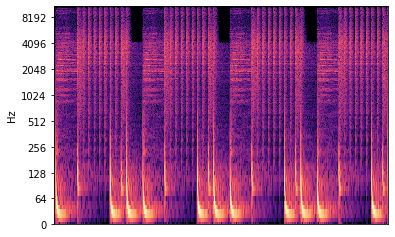

In [ ]:
sr = 44100   
style = 'audio_style_transfer/sounds/corpus/johntejada-1.wav'
audio, _ = librosa.core.load(style, sr=sr)
plot_spec(audio)

In [ ]:
Audio(audio, rate=sr)

Now the content:

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


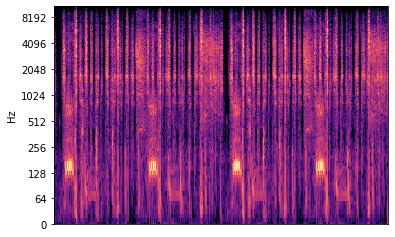

In [ ]:
content = 'audio_style_transfer/sounds/target/beat-box-1.wav'
audio, _ = librosa.core.load(content, sr=sr)
plot_spec(audio)

In [ ]:
Audio(audio, rate=sr)

And now let's try synthesizing.  In general, most parameters with higher settings produce more desirable results (except for `hop_length` and `stride` which are often better with smaller values).

In [ ]:
timedomain.run(
    content,
    style,
    'synthesis.wav',
    n_fft=4096,          # 512 to sr / 2. Higher is better quality but is slower.
    n_layers=1,          # 1 to 3. Higher is better quality but is slower.
    n_filters=2048,      # 512 - 4096. Higher is better quality but is slower.
    hop_length=256,      # 256 to n_fft / 2. The lower this value, the better the temporal resolution.
    alpha=0.0005,        # 0.0001 to 0.01. The higher this value, the more of the original "content" bleeds through.
    k_w=4,               # 3 to 5. The higher this value, the more complex the patterns it can synthesize.
    iterations=300,      # 100 to 1000. Higher is better quality but is slower.
    stride=1,            # 1 to 3. Lower is better quality but is slower.
    sr=sr,
)

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 40681.804688
  Number of iterations: 300
  Number of functions evaluations: 309


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


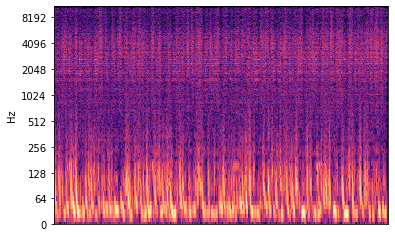

In [ ]:
audio, _ = librosa.core.load('synthesis.wav', sr=sr)
plot_spec(audio)

In [ ]:
Audio(audio, rate=sr)